In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import datetime
import pytz

Código que irá plotar gráficos de porcentagem de ocupações e reservas para cada minuto do dia.

### Lendo e filtrando os dados coletados da API

In [ ]:
# Lendo dados coletados da API
df = pd.read_csv('modo_data.csv', usecols=[0,2,3,5])

In [2]:
def str_to_datetime(df_time):
    """ 
    Reformatando de string para datetime.
    
    Parameters
    ----------
    df_time : pandas.DataFrame, string
        Dataframe com strings a serem convertidas para datetime.
    
    Returns
    ----------
    date_list : pandas.DataFrame, datetime
        Dataframe com valores em datetime para possíveis fusos de Vancouver.
    
    """
    date_list = []
    
    # Formatos de fuso horário comum de Vancouver e 
    # fuso horário característico de horário de verão
    format_string = ['%Y-%m-%d %H:%M:%S.%f-08:00', '%Y-%m-%d %H:%M:%S.%f-07:00',
                     '%Y-%m-%d %H:%M:%S-08:00', '%Y-%m-%d %H:%M:%S-07:00']
    
    print(datetime.datetime.now())
    for date in df_time:
        erro = True
        for fmt in format_string:
            try:
                date_list.append(datetime.datetime.strptime(str(date), fmt))
                break
                erro = False
            except:
                pass
        
        if erro:
            print('Erro in: '+str(date))
            
            
    print(datetime.datetime.now())
    return pd.DataFrame(date_list)

In [ ]:
# Retirando dados nan
df.dropna(axis=0, how='any', inplace=True)

# Convertendo datetime strings para o tipo datetime
df['Capture_time'] = str_to_datetime(df['Capture_time'])

# Colleting vehicle ids
car_ids = list(df.CarID.unique())

In [3]:
def convert_datetime_timezone(dt, tz1, tz2):
    """
    Converte uma hora no fuso UTC ou São Paulo para um provável fuso de Vancouver.
    
    Parameters
    ------------
    dt : unix timestamp
        Timestamp a ser convertido para outro fuso horário.
    
    tz1, tz2 : Timezone String
        Time zone atual e a que a hora irá ser convertida.
    
    Returns
    ----------
    dt : unix timestamp
        Timestamp já convertida para o fuso de Vancouver.
    
    """    
    
    tz1 = pytz.timezone(tz1)
    tz2 = pytz.timezone(tz2)

    dt = datetime.datetime.fromtimestamp(dt)
    dt = datetime.datetime.strptime(str(dt),"%Y-%m-%d %H:%M:%S")
    dt = tz1.localize(dt)
    dt = dt.astimezone(tz2)
    
    # Formatos de fuso horário comum de Vancouver e 
    # fuso horário característico de horário de verão
    format_string = ['%Y-%m-%d %H:%M:%S.%f-08:00', '%Y-%m-%d %H:%M:%S.%f-07:00',
                     '%Y-%m-%d %H:%M:%S-08:00', '%Y-%m-%d %H:%M:%S-07:00']
    

    for fmt in format_string:
        erro = True
        try:
            dt = datetime.datetime.strptime(str(dt), fmt)
            erro = False
            break
        except:
            pass
    
    if erro:
        print('Erro in: '+str(date))
    
    dt = int(dt.timestamp())

    return dt

In [ ]:
# Eliminando intervalos de disponibilidade futuros
print ('Size with future interval: '+str(len(df)))

# Separando o dataframe com os intervalos futuros
df_with_future = df
df = pd.DataFrame()

# Ordenando por capture time e pelo start time
df_with_future.sort_values(by=['Capture_time', 'StartTime'], inplace=True)

for car in car_ids:
    # Refazendo o dataframe somente com os intervalos presentes
    # já que a api retorna os intervalos de disponibilidade futuros
    df = df.append(df_with_future[df_with_future['CarID'] == car].drop_duplicates(subset='Capture_time', keep='first'))

print ('Size without future interval: '+str(len(df)))

df.sort_values(by='Capture_time', inplace=True)

# Retirando dados nan
df.dropna(axis=0, how='any', inplace=True)

## Porcentagem de carros ocupados a cada minuto

Realizando a coleta de veículos ocupados a cada minuto dos dados, com o seguinte método:<br>
Se o veículo estiver disponível somente em um intervalo futuro, então ele está ocupado neste minuto analisado.

In [ ]:
print(datetime.datetime.now())

df = df.sort_values(by='Capture_time')
# Series with each collected minute
dates = pd.Series(df.Capture_time.unique())
busy_weekdays = []
busy_weekends = []

# Going through each date in order to count the number of cars in travel.
for dt in dates:
    in_travel = len(df[(df['Capture_time'] == dt) & (df['StartTime'] > df['RequestStart'])])
    percentage = (in_travel/len(car_ids))*100
    
    # Sorting out per week day
    if dt.weekday() <= 4: # Monday == 0 .. Sunday == 6
        busy_weekdays.append([int(dt.timestamp()), in_travel, percentage])
    else: 
        busy_weekends.append([int(dt.timestamp()), in_travel, percentage])
        

dfIn_Travel_weekdays = pd.DataFrame(busy_weekdays, columns=['capture_time', 'total_in_travel', 'percentage'])
dfIn_Travel_weekends = pd.DataFrame(busy_weekends, columns=['capture_time', 'total_in_travel', 'percentage'])

print(datetime.datetime.now())

In [4]:
def from_timestamp_list(timestamp_list):
    
    datetime_list = []
    
    for date in timestamp_list:
        datetime_list.append(datetime.datetime.fromtimestamp(int(date)))
    
    return pd.DataFrame(datetime_list)

In [ ]:
# Formatando os dados de unix timestamp para datetime

dfWeekdays = dfIn_Travel_weekdays

dfWeekdays['capture_time'] = from_timestamp_list(dfWeekdays['capture_time'])    
    
    
dfWeekends = dfIn_Travel_weekends

dfWeekends['capture_time'] = from_timestamp_list(dfWeekends['capture_time'])

In [ ]:
# Salvando dados já processados
dfWeekends.to_csv('weekends_v2.csv', index=False, encoding='utf-8')
dfWeekdays.to_csv('weekdays_v2.csv', index=False, encoding='utf-8')

In [5]:
# Leitura de dados já processados se necessário

dfWeekends = pd.read_csv('../paper/data/weekends.csv')
dfWeekdays = pd.read_csv('../paper/data/weekdays.csv')

dfWeekdays['capture_time'] = pd.to_datetime(dfWeekdays['capture_time'])
dfWeekends['capture_time'] = pd.to_datetime(dfWeekends['capture_time'])

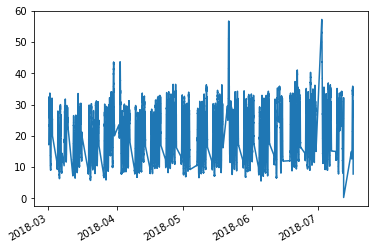

In [9]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfWeekdays['capture_time'],dfWeekdays['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

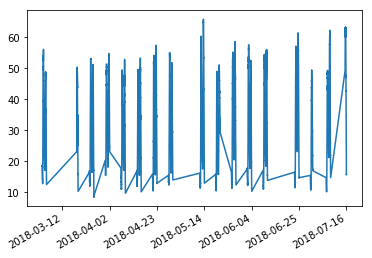

In [10]:
# Plot da porcentagem de carros alocados em dias de final de semana
plt.plot(dfWeekends['capture_time'],dfWeekends['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

## Porcentagem média de carros ocupados em cada minuto

Importante função que realiza a porcentagem média para todos os minutos do intervalo de coleta, assim organizando minuto a minuto a porcentagem respectiva.

In [6]:
def media(df): 
    """
    Faz a media das porcentagens minuto a minuto de todo o dataset.
    
    Parameters
    ------------
    df : Pandas dataframe
        Dados a serem analisados, com uma coluna dos horários e outra com as porcentagens.
    
    Returns
    ----------
    media : Pandas dataframe
        Dados com a média das porcentagens para 24 horas.
    
    """
    minute = []

    # Criando uma coluna que irá sinalizar a quantidade de minutos corridos até tal registro
    df['minute'] = df.capture_time.dt.minute + (df.capture_time.dt.hour * 60)
    
    # Ordenando o dataset por minutos corridos para facilitar a soma de valores
    df = df.sort_values(by=['minute', 'capture_time'])
    
    min_list = list(df['minute'].unique())
    media = []
    # É percorrido minuto a minuto para se obter a média de porcentagem para cada
    # Assim é formado um dataframe com média de utilização a cada minuto
    for min in min_list:

        occurencies = df[df.minute == min]
    
        media.append([occurencies.capture_time.iloc[0].strftime('%H:%M'), 
                      float(occurencies.percentage.mean()), 
                      float(occurencies.percentage.std())])
    

    media = pd.DataFrame(media, columns=['time', 'mean', 'std'])
    
    return media

In [7]:
# Fazendo a média das porcentagens de cada dia
dfWeekdays = dfWeekdays.sort_values(by='capture_time')
mediaWeekdays = media(dfWeekdays)

dfWeekends = dfWeekends.sort_values(by='capture_time')
mediaWeekends = media(dfWeekends)

In [ ]:
# Salvando dados já processados
mediaWeekdays.to_csv('mediaWeekdays_v2.csv', index=False, encoding='utf-8')
mediaWeekends.to_csv('mediaWeekends_v2.csv', index=False, encoding='utf-8')

In [ ]:
# Leitura de dados já processados se necessário

# mediaWeekdays = pd.read_csv('mediaWeekdays_v2.csv')
# mediaWeekends = pd.read_csv('mediaWeekends_v2.csv')

In [8]:
# Ordenando pelo tempo
mediaWeekdays = mediaWeekdays.sort_values(by=['time'])
mediaWeekends = mediaWeekends.sort_values(by=['time'])

## Gráficos de porcentagem média de carros ocupados em cada minuto

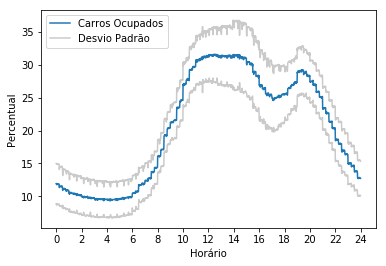

In [9]:

# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Carros Ocupados')

# Curvas representando o intervalo de desvio padrão
ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']+mediaWeekdays['std'], alpha=150, c='gray', label='Desvio Padrão')
ax.plot(range(len(mediaWeekdays['time'])), mediaWeekdays['mean']-mediaWeekdays['std'], alpha=150, c='gray')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Legendas e label dos eixos
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
plt.ylabel('Percentual')
plt.xlabel('Horário')

# Salvando o plot
# plt.savefig('Weekdays_v2.pdf', bbox_inches='tight')

plt.show()

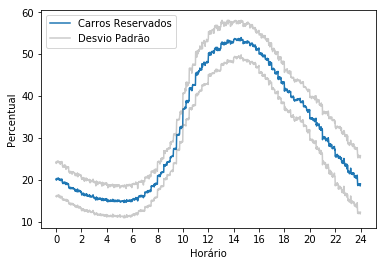

In [10]:
# Plot da media das porcentagens dos dias de semana
fig, ax = plt.subplots()
# Curva dos carros andando
ax.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Carros Reservados')

# Curvas representando o intervalo de desvio padrão
ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']+mediaWeekends['std'], alpha=150, c='gray', label='Desvio Padrão')
ax.plot(range(len(mediaWeekends['time'])), mediaWeekends['mean']-mediaWeekends['std'], alpha=150, c='gray')

# Modificando os labels das horas
ax.xaxis.set_ticks(np.arange(0, 1441, 120))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Legendas e label dos eixos
plt.legend(bbox_to_anchor=(0.01, 0.99), loc=2, borderaxespad=0.2)
plt.ylabel('Percentual')
plt.xlabel('Horário')

# Salvando o plot
# plt.savefig('Weekends_v2.pdf', bbox_inches='tight')

plt.show()

## Extração das porcentagens de carros reservados

In [11]:
# CSV criado a partir dos dados coletados do arquivo ModoApi_Data_Filter
dfTravels = pd.read_csv('../paper/data/travels.csv')

In [12]:
# Ordenando por id e inicio do tempo de reserva
dfTravels = dfTravels.sort_values(by=['car_id', 'start'])

In [ ]:
# Função desnecessária para o algoritmo atual de contagem de reservas
def concat_consec():
    # Concatenando reservas consecutivas
    # Enquanto estiver com viagens consecutivas percorrer o dataframe
    while (len(dfTravels[dfTravels['only_new_reserves'] == False]) > 0):
        i = 0
        while(i < len(dfTravels)-1):
            # Se a viagem atual for comum e a seguinte consecutiva, analisar a possível concatenação
            if (dfTravels['only_new_reserves'].iloc[i] and 
                not dfTravels['only_new_reserves'].iloc[i+1]):

                # Se a viagem consecutiva terminar depois da viagem anterior efetuar concatenação
                if (dfTravels['end'].iloc[i] < dfTravels['end'].iloc[i+1]):
                    dfTravels['end'].iloc[i] = dfTravels['end'].iloc[i+1]

                # Caso contrario, somente retirar do dataframe a viagem consecutiva
                dfTravels = dfTravels.drop(dfTravels.index[i+1])
                dfTravels.index = range(len(dfTravels))
                i -= 1

            i+=1

    dfTravels.index = range(len(dfTravels))
    dfTravels.to_csv('travels_concat_v2.csv')

###  Função para contar a porcentagem de carros reservados nos dias passados como parâmetro

Realizando a coleta das porcentagens de reservas com o seguinte algoritmo:<br><br>
Inicialmente necessito de lista de todos os minutos de coleta e outra com todos os intervalos de reserva para cada veículo.<br>
A partir disso construimos uma timeline para cada carro, percorrendo todos os minutos de coleta. A timeline é montada analisando se no minuto atual existe alguma reserva que o engloba, assim é adicionado um inteiro para representar que ele estava reservado em tal minuto. Assim realizo a soma das timelines de cada veículo e calculo a média pela quantidade de veículos, para cada minuto.
>Nota: Tal algoritmo não é o mais otimizado, porém torna o método mais intuítivo e com uma menor chance de ocorrer erros.<br>
A forma mais otimizada seria percorrer todos os minutos e verificar quantas reservas registradas englobam tal minuto, porém tal método pode gerar erros se não adaptado corretamente ao nosso contexto de dados.

In [13]:
def cont_reservas(dfDays):
    """
    Conta o número de reservas de todos os minutos de coleta para realizar uma média.
    
    Parameters
    ------------
    dfDays: Pandas dataframe
        Dados de todos os minutos de coleta a serem avaliados.
    
    Returns
    ----------
    media : Pandas dataframe
        Dados com a média das porcentagens para 24 horas.
    """
    
    # Filtering the capture times
    datas = dfDays.capture_time

    reservas = []
    # Preparing a dataset to make the intervals 
    dfReservas = pd.DataFrame()
    dfReservas['car_id'] = dfTravels['car_id']
    dfReservas['start'] = dfTravels['start']
    dfReservas['end'] = dfTravels['end']

    dfReservas = dfReservas.sort_values(by='start')
    
    print(datetime.datetime.now())
    
    """ Going through the dates counting the occurrences 
    of the current date between the travels intervals """
    for dt in datas:
        timestamp = int(dt.timestamp())
        # start travel < current date < end travel
        cont_reservas = len(dfReservas[(dfReservas['start'] <= timestamp) & 
                                       (timestamp <= dfReservas['end'])]['car_id'].unique())

        porcentagem = (cont_reservas/len(car_ids))*100

        reservas.append([dt, cont_reservas, porcentagem])   
        
    print(datetime.datetime.now())
    reservas = pd.DataFrame(reservas, columns=['time', 'total_reserves', 'percentage'])

    return reservas

In [12]:
# Contando reservas durante os dias de coleta
dfR_Weekdays = cont_reservas(dfWeekdays)
dfR_Weekends = cont_reservas(dfWeekends)

2018-11-08 14:31:27.387647


NameError: name 'car_ids' is not defined

In [ ]:
dfR_Weekends.to_csv('r_weekends_v2.csv', index=False, encoding='utf-8')
dfR_Weekdays.to_csv('r_weekdays_v2.csv', index=False, encoding='utf-8')

In [14]:
# Leitura de dados já processados se necessário

dfR_Weekdays =  pd.read_csv('../paper/data/r_weekdays.csv')
dfR_Weekends =  pd.read_csv('../paper/data/r_weekends.csv')

# Formatando os dias para datetime

dfR_Weekdays['time'] = pd.to_datetime(dfR_Weekdays['time'])
dfR_Weekends['time'] = pd.to_datetime(dfR_Weekends['time'])

In [ ]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfR_Weekdays['time'],dfR_Weekdays['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [ ]:
# Plot da porcentagem de carros alocados em dias de semana
plt.plot(dfR_Weekends['datetime'],dfR_Weekends['percentage'])
plt.gcf().autofmt_xdate()
plt.show()

In [15]:
# Fazendo a média das porcentagens de cada dia

# Dias de semana
dfR_Weekdays = dfR_Weekdays.sort_values(by='time')
dfR_Weekdays['capture_time'] = dfR_Weekdays['time']
dfmediaR_Weekdays = media(dfR_Weekdays)

# Ordenando pelo tempo
dfmediaR_Weekdays = dfmediaR_Weekdays.sort_values(by='time')

# dfmediaR_Weekdays.to_csv('media_r_weekdays.csv', index=False, encoding='utf-8')

# Finais de semana
dfR_Weekends = dfR_Weekends.sort_values(by='time')
dfR_Weekends['capture_time'] = dfR_Weekends['time']
dfmediaR_Weekends = media(dfR_Weekends)

# Ordenando pelo tempo
dfmediaR_Weekends = dfmediaR_Weekends.sort_values(by='time')

# dfmediaR_Weekends.to_csṿ('media_r_weekends.csv', index=False, encoding='utf-8')

## Plotagem final da porcentagem de carros reservados e ocupados

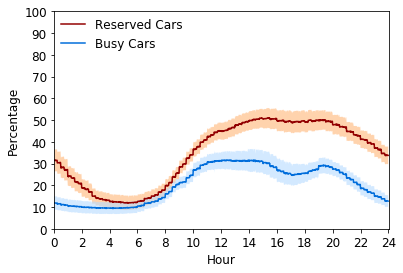

In [28]:

fig, ax = plt.subplots()

# Curva dos carros reservados
ax.plot(range(len(dfmediaR_Weekdays['time'])),dfmediaR_Weekdays['mean'], label='Reserved Cars', c='#920000')

# Curvas representando o intervalo de desvio padrão
ax.fill_between(range(len(dfmediaR_Weekdays['time'])),dfmediaR_Weekdays['mean']+dfmediaR_Weekdays['std'], 
                dfmediaR_Weekdays['mean']-dfmediaR_Weekdays['std'], facecolor='#ffb677', alpha=0.6)

# Curva dos carros andando

ax.plot(range(len(mediaWeekdays['time'])),mediaWeekdays['mean'], label='Busy Cars', c="#006ddb")

# Curvas representando o intervalo de desvio padrão
ax.fill_between(range(len(mediaWeekdays['time'])),mediaWeekdays['mean']+mediaWeekdays['std'], 
                mediaWeekdays['mean']-mediaWeekdays['std'], facecolor='#b6dbff', alpha=0.6)

# Modificando os labels das horas e das porcentagens
ax.xaxis.set_ticks(np.arange(0, 1441, 120))
ax.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax.set_ylim([0,100])
ax.set_xlim([0,1441])

# Legendas e label dos eixos
ax.legend(loc=2, borderaxespad=0.2, frameon=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Hour')

# plt.show()
plt.savefig('../paper/plots/weekdays.pdf', bbox_inches='tight')

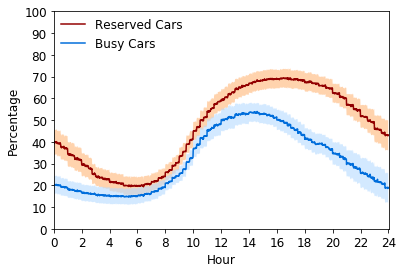

In [29]:

fig, ax = plt.subplots()

# Curva dos carros reservados
ax.plot(range(len(dfmediaR_Weekends['time'])),dfmediaR_Weekends['mean'], label='Reserved Cars', c='#920000')

# # Curvas representando o intervalo de desvio padrão
ax.fill_between(range(len(dfmediaR_Weekends['time'])),dfmediaR_Weekends['mean']+dfmediaR_Weekends['std'], 
                dfmediaR_Weekends['mean']-dfmediaR_Weekends['std'], facecolor='#ffb677', alpha=0.6)

# Curva dos carros andando
ax.plot(range(len(mediaWeekends['time'])),mediaWeekends['mean'], label='Busy Cars', c="#006ddb")

# Curvas representando o intervalo de desvio padrão
ax.fill_between(range(len(mediaWeekends['time'])),mediaWeekends['mean']+mediaWeekends['std'], 
                mediaWeekends['mean']-mediaWeekends['std'], facecolor='#b6dbff', alpha=0.6)


# Modificando os labels das horas e das porcentagens
ax.xaxis.set_ticks(np.arange(0, 1441, 120))
ax.yaxis.set_ticks(np.arange(0, 110, 10))

fig.canvas.draw()

labels = [item.get_text() for item in ax2.get_xticklabels()]
labels = range(0,26,2)

ax.set_xticklabels(labels)

# Eixo y de 0 a 100%
ax.set_ylim([0,100])
ax.set_xlim([0,1441])

# Legendas e label dos eixos
ax.legend(loc=2, borderaxespad=0.2, frameon=False)
ax.set_ylabel('Percentage')
ax.set_xlabel('Hour')


# plt.show()
plt.savefig('../paper/plots/weekends.pdf', bbox_inches='tight')